In [2]:
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation, FuncAnimation
import numpy as np
import pandas as pd
import os
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

In [3]:
#dnbr = np.load('../../cloud_control_data_dnbr.npz')['dnbr']
dnbr = np.load('/Users/jincui/Downloads/landsat_analysis/adjacency.npz')['dnbr']
dnbr = dnbr[:,200:1200,200:1200,:]

labs = (dnbr>0.66).astype(int)
water_mask = np.load('../../water_mask_based_on_ndvi_565.npy')
water_mask = np.expand_dims(water_mask, 2)
for i in range(len(labs)):
    labs[i,:][water_mask==1] = 0

dnbr = dnbr.astype('float64')
dnbr_medians = np.zeros(len(dnbr))
for i in range(len(dnbr)):
    dnbr_medians[i] = np.median(dnbr[i,:,:,0]).round(2)
 

In [3]:
'''
imgs = np.load('../../../cloud_control_data.npz')['imgs']
smooth = 1e-5
b08 = imgs[:,:,:,7:8] 
b04 = imgs[:,:,:,3:4]
b12 = imgs[:,:,:,11:12]
ndvi= (b08-b04+smooth)/(b08+b04+smooth)
nbr = (b08-b12+smooth)/(b08+b12+smooth)
'''

In [4]:
bigquery_res = pd.read_csv('/Volumes/My Passport for Mac/sentinel_2_53HPA/bigquery_results_s.csv', index_col=0)
bigquery_res['sensing_time'] = pd.to_datetime(bigquery_res['sensing_time'])
bigquery_res = bigquery_res.reset_index(drop=True)
subset_idx = np.array(bigquery_res[bigquery_res['cloud_cover']<75].index)
bigquery_res_s = bigquery_res.iloc[subset_idx,:]
bigquery_res_s = bigquery_res_s.reset_index(drop=True)


In [16]:
from tqdm import tqdm_notebook
import rasterio
id_names = ['L1C_T53HPA_A023837_20200115T004700','L1C_T53HPA_A015000_20200120T005618','L1C_T53HPA_A023980_20200125T004659', 'L1C_T53HPA_A015143_20200130T005534']
def concat_bands(name='L1C_T53HPA_A004418_20180110T005319', 
                 BASE = '/Volumes/My Passport for Mac/sentinel_2_53HPA/'
                 ):
    '''Resize all bands to (5490, 5490), resolution at 20meter/pixel'''

    b01 = rasterio.open(BASE+name+'_b01.tif').read(1)
    b01 = np.expand_dims(cv2.resize(b01, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b09 = rasterio.open(BASE+name+'_b09.tif').read(1)
    b09 = np.expand_dims(cv2.resize(b09, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b10 = rasterio.open(BASE+name+'_b10.tif').read(1)
    b10 = np.expand_dims(cv2.resize(b10, (5490,5490)), axis=2)[3000:4000,2200:3200,:]

    b02 = rasterio.open(BASE+name+'_b02.tif').read(1)
    b02 = np.expand_dims(cv2.resize(b02, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b03 = rasterio.open(BASE+name+'_b03.tif').read(1)
    b03 = np.expand_dims(cv2.resize(b03, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b04 = rasterio.open(BASE+name+'_b04.tif').read(1)
    b04 = np.expand_dims(cv2.resize(b04, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b08 = rasterio.open(BASE+name+'_b08.tif').read(1)
    b08 = np.expand_dims(cv2.resize(b08, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    tci = rasterio.open(BASE+name+'_tci.tif').read(1)
    tci = np.expand_dims(cv2.resize(tci, (5490,5490)), axis=2)[3000:4000,2200:3200,:]

    b05 = np.expand_dims(rasterio.open(BASE+name+'_b05.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b06 = np.expand_dims(rasterio.open(BASE+name+'_b06.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b07 = np.expand_dims(rasterio.open(BASE+name+'_b07.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b8A = np.expand_dims(rasterio.open(BASE+name+'_b8A.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b11 = np.expand_dims(rasterio.open(BASE+name+'_b11.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b12 = np.expand_dims(rasterio.open(BASE+name+'_b12.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    
    concat = np.concatenate([b01,b02,b03,b04,b05,b06,b07,b08,b09,b10,b11,b12,b8A,tci],axis=-1)
    concat = np.expand_dims(concat, 0)
    return concat

for i in tqdm_notebook(range(len(id_names))):
    if i == 0:
        test_imgs = concat_bands(id_names[i])
    else:
        test_imgs = np.concatenate([test_imgs, concat_bands(id_names[i])])

smooth = 1e-5
test_nbr = (test_imgs[:,:,:,7:8]-test_imgs[:,:,:,11:12]+smooth) / (test_imgs[:,:,:,7:8]+test_imgs[:,:,:,11:12]+smooth)
test_nbr.shape
test_dnbr = np.zeros((3,1000,1000,1))
for i in range(len(test_dnbr)):
    test_dnbr[i,:] = test_nbr[i,:] - test_nbr[i+1,:]

In [18]:
all_dnbr = np.concatenate([dnbr, test_dnbr],0)
all_dnbr.shape

(111, 1000, 1000, 1)

In [42]:
dates = np.concatenate([bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t)).values, np.array(['2020-01-20','2020-01-25','2020-01-30'])])
all_labs = (all_dnbr > 0.66).astype(int)


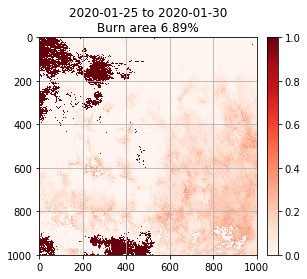

In [60]:
fig = plt.figure()

##### idx 0-35
i=-1
MAX=36

##### idx 36-71
i=35
MAX=72

#### idx 72-107
i=71
MAX=108

i=-1
MAX=113

#im = plt.imshow(dnbr[i,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1, animated=True)
im = plt.imshow(all_dnbr[i,:,:,0], cmap='Reds', vmin=0, vmax=1, animated=True)

plt.colorbar(fraction=0.045, pad=0.03)

plt.grid(True)
thres = 0.66
#title = plt.title(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]} cloud_cover: {bigquery_res_s['cloud_cover'][i+1].round(2)}%\n median dNBR: {dnbr_medians[i]} burnt area {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%")
title = plt.title(f"{dates[i-2]} to {dates[i-1]}\nburnt area {(100*(all_labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
def updatefig(*args):
    global i
    if (i<=MAX):
        i += 1
    else:
        pass
    #im.set_array(dnbr[i-2,:,:,0])
    im.set_array(all_dnbr[i-2,:,:,0])
    #title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\n median dNBR: {dnbr_medians[i-2]} burnt area {(100*(labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
    title.set_text(f"{dates[i-2]} to {dates[i-1]}\nBurn area {(100*(all_labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
    return im, title

#ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=109)
ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=113)

plt.show()



In [61]:
#ani.save('dNBR_anim_0.gif', fps=4, extra_args=['-vcodec', 'libx264'])
#ani.save('dNBR_anim_1.gif', fps=4, extra_args=['-vcodec', 'libx264'])
#ani.save('dNBR_anim_2.gif', fps=4, extra_args=['-vcodec', 'libx264'])
ani.save('dNBR_anim_total.gif', fps=4, extra_args=['-vcodec', 'libx264'])
#ani.save('dNBR_anim_total_2.gif', fps=2, extra_args=['-vcodec', 'libx264'])
#ani.save('dNBR_anim_total_15.gif', fps=1.5, extra_args=['-vcodec', 'libx264'])
#ani.save('dNBR_anim_total_1.gif', fps=1, extra_args=['-vcodec', 'libx264'])
#ani.save('dNBR_anim_total_09.gif', fps=0.9, extra_args=['-vcodec', 'libx264'])



MovieWriter ffmpeg unavailable. Trying to use pillow instead.


IndexError: index 111 is out of bounds for axis 0 with size 111

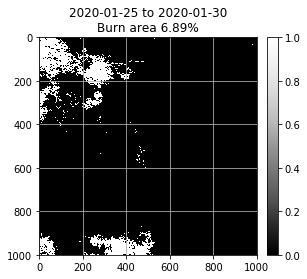

In [63]:
fig = plt.figure()

##### idx 0-35
i=-1
MAX=36

##### idx 36-71
i=35
MAX=72

#### idx 72-107
i=71
MAX=108

i=-1
MAX=113

#im = plt.imshow(dnbr[i,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1, animated=True)
im = plt.imshow((all_dnbr[i,:,:,0]>0.66).astype(int), cmap='Greys_r', vmin=0, vmax=1, animated=True)

plt.colorbar(fraction=0.045, pad=0.03)

plt.grid(True)
thres = 0.66
#title = plt.title(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]} cloud_cover: {bigquery_res_s['cloud_cover'][i+1].round(2)}%\n median dNBR: {dnbr_medians[i]} burnt area {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%")
title = plt.title(f"{dates[i-2]} to {dates[i-1]}\nburnt area {(100*(all_labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
def updatefig(*args):
    global i
    if (i<=MAX):
        i += 1
    else:
        pass
    #im.set_array(dnbr[i-2,:,:,0])
    im.set_array((all_dnbr[i-2,:,:,0]>0.66).astype(int))
    #title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\n median dNBR: {dnbr_medians[i-2]} burnt area {(100*(labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
    title.set_text(f"{dates[i-2]} to {dates[i-1]}\nBurn area {(100*(all_labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
    return im, title

#ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=109)
ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=113)

plt.show()



In [64]:
ani.save('burn_anim_total.gif', fps=4, extra_args=['-vcodec', 'libx264'])


MovieWriter ffmpeg unavailable. Trying to use pillow instead.


IndexError: index 111 is out of bounds for axis 0 with size 111

In [65]:
all_risks = np.zeros(all_labs.shape)
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(25)):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    for j in range(len(labs)):
        if all_labs[j,row_idx:row_idx+200,col_idx:col_idx+200,0].sum() >= 0.05*200*200:
            all_risks[j,row_idx:row_idx+200,col_idx:col_idx+200,0] = 1
            

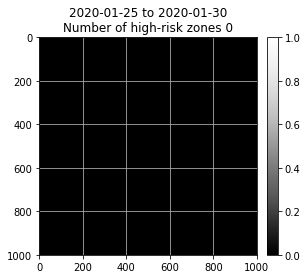

In [77]:
fig = plt.figure()

##### idx 0-35
i=-1
MAX=36

##### idx 36-71
i=35
MAX=72

#### idx 72-107
i=71
MAX=108

i=-1
MAX=113

#im = plt.imshow(dnbr[i,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1, animated=True)
im = plt.imshow((all_risks[i,:,:,0]>0.66).astype(int), cmap='Greys_r', vmin=0, vmax=1, animated=True)

plt.colorbar(fraction=0.045, pad=0.03)

plt.grid(True)
thres = 0.66
#title = plt.title(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]} cloud_cover: {bigquery_res_s['cloud_cover'][i+1].round(2)}%\n median dNBR: {dnbr_medians[i]} burnt area {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%")
title = plt.title(f"{dates[i-2]} to {dates[i-1]}\nNumber of high-risk zones {(all_risks[i-2].sum() // (200*200)).astype(int)}%")
def updatefig(*args):
    global i
    if (i<=MAX):
        i += 1
    else:
        pass
    #im.set_array(dnbr[i-2,:,:,0])
    im.set_array((all_risks[i-2,:,:,0]>0.66).astype(int))
    #title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\n median dNBR: {dnbr_medians[i-2]} burnt area {(100*(labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
    title.set_text(f"{dates[i-2]} to {dates[i-1]}\nNumber of high-risk zones {(all_risks[i-2].sum()//(200*200)).astype(int)}")
    return im, title

#ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=109)
ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=113)

plt.show()



In [78]:
ani.save('risk_anim_total.gif', fps=4, extra_args=['-vcodec', 'libx264'])


MovieWriter ffmpeg unavailable. Trying to use pillow instead.


IndexError: index 111 is out of bounds for axis 0 with size 111

In [ ]:
fig = plt.figure()

##### idx 0-35
i=-1
MAX=36

##### idx 36-71
i=35
MAX=72

#### idx 72-107
i=71
MAX=108


#im = plt.imshow(dnbr[i,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1, animated=True)
im = plt.imshow(dnbr[i,:,:,0], cmap='Reds', vmin=0, vmax=1, animated=True)

plt.colorbar(fraction=0.045, pad=0.03)

plt.grid(True)
thres = 0.66
title = plt.title(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]} cloud_cover: {bigquery_res_s['cloud_cover'][i+1].round(2)}%\n median dNBR: {dnbr_medians[i]} burnt area {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%")

def updatefig(*args):
    global i
    if (i<=MAX):
        i += 1
    else:
        pass
    #im.set_array(dnbr[i-2,:,:,0])
    im.set_array(dnbr[i-2,:,:,0])
    title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\n median dNBR: {dnbr_medians[i-2]} burnt area {(100*(labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
    return im, title

ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=109)

plt.show()



In [13]:
risks = np.zeros(labs.shape)
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(25)):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    for j in range(len(labs)):
        if labs[j,row_idx:row_idx+200,col_idx:col_idx+200,0].sum() >= 0.05*200*200:
            risks[j,row_idx:row_idx+200,col_idx:col_idx+200,0] = 1

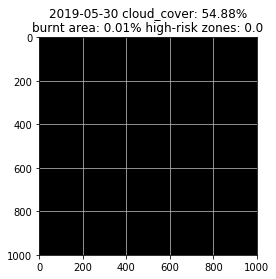

In [18]:
fig = plt.figure()

##### idx 0-35
i=-1
MAX=36

##### idx 36-71
i=35
MAX=72

#### idx 72-107
i=71
MAX=108

im = plt.imshow(risks[i,:,:,0], cmap='Greys_r', vmin=0, vmax=1, animated=True)
plt.grid(True)

thres = 0.66
title = plt.title(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]} cloud_cover: {bigquery_res_s['cloud_cover'][i+1].round(2)}%\n median dNBR: {dnbr_medians[i]} burnt area {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%\n high-risk zones: {risks[i,:,:,0].sum()//(40000)}")

def updatefig(*args):
    
    global i
    if (i<=MAX):
        i += 1
    else:
        pass
    im.set_array(risks[i-2,:,:,0])
    #title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\nburnt area: {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}% high-risk zones: {risks[i-2,:,:,0].sum()//(40000)}")
    title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\nburnt area: {(100*(labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}% high-risk zones: {risks[i-2,:,:,0].sum()//(40000)}")
    return im, title,

ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=109)
plt.show()


In [19]:
#ani.save('risks_anim_0.gif', fps=4, extra_args=['-vcodec', 'libx264'])   # 01/15/2018 to 10/02/2018
#ani.save('risks_anim_1.gif', fps=4, extra_args=['-vcodec', 'libx264'])   # 10/07/2018 to 06/04/2019
ani.save('risks_anim_2.gif', fps=4, extra_args=['-vcodec', 'libx264'])   # 06/14/2019 to 01/15/2020


MovieWriter ffmpeg unavailable. Trying to use pillow instead.
